# 1 - Importing all the required modules and the functions.py file that contains our custom made functions

In [1]:
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import getpass
import glob

import functions
import spectrogram_plotting_functions
import scipy.stats
importlib.reload(functions) #loads our custom made functions.py file
importlib.reload(spectrogram_plotting_functions)


<module 'spectrogram_plotting_functions' from 'c:\\Users\\Thomas\\Desktop\\cpl_analysis_naman\\spectrogram_plotting_functions.py'>

# 2 - Loading the data files

This code fetches the current 'user' by using getpass. Then it sets the basepath, loads the files and specifies the savepath. Note that the basepath, files and savepath need to be changed depending on where you have kept the files and where you want the results to be stored. In this case, I have set it up to be in a particular folder in my Dropbox account, which is stored locally.

In [2]:
#Fetch the current user
user= (getpass.getuser())
print("Hello", user)

#Set the basepath, savepath and load the data files
base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat\\*.mat')
savepath = base+'\\results\\'
print(files)

Hello Thomas
['C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230529_dk1_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230529_dk3_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230529_dk5_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230529_dk6_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230531_dk1_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230531_dk3_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230531_dk5_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230531_dk6_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230609_dk1_BW_nocontext_day1.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230609_dk3_BW_nocontext_day1.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230610_dk1_BW_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230610_dk3_BW_noconte

# 3 Extracting band data around events and saving it in a dataframe

1.  The keyboard dict maps the keyboard codes that were the annotation in .mat files to their meanings. '98':'b' is the beginning of a black trial,'119':'w' is the beginning of a white trial,'120':'nc' is the beginning of a no context trial,'49':'1' signifies a correct dig by the rat,'48':'0' signifies an incorrect dig by the rat.
2. Then we initialize some empty dictionaries and dataframes to store data.
3. Then we start looping through each of the data files.
4. We first get the basename of the file using `os.path.basename(file)`
5. We split the basename using `os.path.splitext(base_name)` , and use  `functions.exp_params` to get the date of the experiment, rat id and the task the rat was doing

In [7]:

keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'} #specifying the map of keyboard annotations to their meanings.

#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat_filtered\\20230615_dk6_BW_context_day1.mat'] #This is just for testing purposes

#Initializing a few empty things to store data
events_codes_all = {}
compiled_data_all_epochs = pd.DataFrame()
compiled_data_list=[]
baseline_lfp_all = []

for file in files: #Looping through data files
    
    ## Get the date, mouse_id and task from the file name
    base_name = os.path.basename(file)
    base_name, _ = os.path.splitext(base_name)
    date, mouse_id, task=functions.exp_params(base_name) #Using a custom made function [see functions.py]
    print(date, mouse_id, task)
    
   
    f=h5py.File(file, 'r')  ## Open the data file
    channels = list(f.keys()) ## Extract channels list from the data file
    print(channels)

    events = functions.identify_events_channel(f, channels) #Extracting events from the data file

    events_codes=np.array(events['codes'][0]) #saving the keyboard annotations of the events (door open, door close etc.)
    events_times=np.array(events['times'][0]) #saving when the events happened
    events_codes_all[base_name] = events_codes #saving the codes in a dictionary to be analyzed later for events other than the ones in our keyboard_dict map
    
    #Generating epochs from events (epochs are basically start of a trial and end of a trial)
    epochs=functions.generate_epochs_with_first_event(events_codes, events_times)

    # Experiment Start time
    first_event=events_times[0]

    for channeli in channels:
        if "AON" in channeli or  "vHp" in channeli :
            
            channel_id=channeli
            # Extracting raw data and time
            data_all=f[channeli]
            raw_data=np.array(data_all['values']).flatten()
            raw_time = np.array(data_all['times']).flatten()
            sampling_rate = int(1/data_all['interval'][0][0])
            print(raw_data.shape, raw_time.shape, sampling_rate)
            notch_filtered_data=functions.iir_notch(raw_data, sampling_rate,60)

            # Normalizing the data by subtracting the mean and std of data 30sec before the first event
            normalized_data,time,data_before=functions.data_normalization(notch_filtered_data,raw_time,first_event, sampling_rate)

            # Extracting baseline waveforms
            baseline_row=[mouse_id,task,channel_id,[data_before], [functions.beta_band(data_before, sampling_rate)], [functions.gamma_band(data_before, sampling_rate)], [functions.theta_band(data_before, sampling_rate)]]
            baseline_lfp_all.append(baseline_row)
            # Extracting the bands
            total=normalized_data
            beta=functions.beta_band(normalized_data, sampling_rate)
            gamma=functions.gamma_band(normalized_data, sampling_rate)
            theta=functions.theta_band(normalized_data, sampling_rate)

            all_bands=[total,beta, gamma, theta]

            for i,epochi in enumerate(epochs):
                
                compiled_data = pd.DataFrame() # Initializing a dataframe to store the data of a single epoch

                door_timestamp = epochi[0][0]
                trial_type = epochi[0][1]
                dig_type = epochi[1, 1]
                dig_timestamp = epochi[1, 0]
                print(door_timestamp,trial_type,dig_timestamp,dig_type)
                
                for bandi in all_bands:
                    
                    data_trial_before, data_trial_after=functions.extract_door_data(bandi,time,door_timestamp,sampling_rate)
                    data_dig_before, data_dig_after=functions.extract_dig_data(bandi,time,dig_timestamp,sampling_rate)

                    # Create a DataFrame for the current bandi
                    bandi_data = pd.DataFrame({
                        'data_trial_before': [data_trial_before],
                        'data_trial_after': [data_trial_after],
                        'data_dig_before': [data_dig_before],
                        'data_dig_after': [data_dig_after]
                    })
                    
                    # Concatenate the current bandi DataFrame with the compiled_data DataFrame along axis=1
                    compiled_data = pd.concat([compiled_data, bandi_data], axis=1)
                
                compiled_data.columns = ['total_pre_door', 'total_post_door', 'total_pre_odor', 'total_post_odor',
                                         'beta_pre_door', 'beta_post_door', 'beta_pre_odor', 'beta_post_odor',
                                         'gamma_pre_door', 'gamma_post_door', 'gamma_pre_odor', 'gamma_post_odor',
                                         'theta_pre_door', 'theta_post_door', 'theta_pre_odor', 'theta_post_odor']
                compiled_data.insert(0, 'rat', mouse_id)
                compiled_data.insert(1, 'date', date)
                compiled_data.insert(2, 'experiment', task)
                compiled_data.insert(3, 'channel', channel_id)
                compiled_data.insert(4, 'trial', i)
                compiled_data.insert(5, 'timestamps', [[door_timestamp, dig_timestamp]])

                compiled_data.insert(6, 'side', keyboard_dict[str(int(trial_type))])
                compiled_data.insert(7, 'correct?', keyboard_dict[str(int(dig_type))])
                compiled_data.insert(8, 'first 30 seconds power', functions.calculate_power_1D(data_before))
                compiled_data.insert(9, 'time', [time])

                compiled_data_list.append(compiled_data)


compiled_data_all_epochs=[]
compiled_data_all_epochs.extend(compiled_data_list)
# Flatten the list of lists
compiled_data_all_epochs = pd.concat(compiled_data_all_epochs, axis=0, ignore_index=True)

baseline_lfp_all = pd.DataFrame(baseline_lfp_all, columns=['rat', 'experiment', 'channel', 'data', 'beta', 'gamma', 'theta'])



20230529 dk1 nocontext
['Keyboard', 'LFP1_AON', 'LFP1_vHp', 'LFP2_AON', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Ref', 'Respirat', 'file']
(1516022,) (1516022,) 2000
notch filter applied
normalizing data
filtering beta band
filtering gamma band
filtering theta band
filtering beta band
filtering gamma band
filtering theta band
181.20385499999998 120.0 182.713855 49.0
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
237.771855 120.0 239.46185499999999 48.0
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
279.551855 120.0 280.29184999999995 49.0
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
348.953855 120.0 349.84385 48.0
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
466.78984999999994 120.0 468.25985499999996 49.0
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
526.9038549999999 120.0 528.223855 49.0
4000 4000
4000 4000
4000 4000
40

In [4]:
# Since the variable size is really big, we can get an idea of how much RAM space is occupied by this variable.
import sys
sys.getsizeof(compiled_data_all_epochs)

42886534744

In [9]:
# Going through the tasks, and renaming the tasks if they contain day2 and os2 suffixes
task_list=np.unique(compiled_data_all_epochs['experiment'])
print(task_list)
compiled_data_all_epochs['experiment'] = compiled_data_all_epochs['experiment'].apply(functions.clean_task)
baseline_lfp_all['experiment'] = baseline_lfp_all['experiment'].apply(functions.clean_task)
task_list=np.unique(compiled_data_all_epochs['experiment'])
print(task_list)

['BWcontext' 'BWnocontext' 'nocontext']
['BWcontext' 'BWnocontext' 'nocontext']


In [6]:
compiled_data_all_epochs.columns

Index(['rat', 'date', 'experiment', 'channel', 'trial', 'timestamps', 'side',
       'correct?', 'first 30 seconds power', 'time', 'total_baseline',
       'beta_baseline', 'gamma_baseline', 'theta_baseline', 'total_pre_door',
       'total_post_door', 'total_pre_odor', 'total_post_odor', 'beta_pre_door',
       'beta_post_door', 'beta_pre_odor', 'beta_post_odor', 'gamma_pre_door',
       'gamma_post_door', 'gamma_pre_odor', 'gamma_post_odor',
       'theta_pre_door', 'theta_post_door', 'theta_pre_odor',
       'theta_post_odor'],
      dtype='object')

Gnerating Waveform of Baseline Data

In [54]:
import numpy as np
import scipy.stats

# Sample data for demonstration
rat = 'dk1'
task = 'BWcontext'
channel = 'AON'
df = baseline_lfp_all[(baseline_lfp_all['rat'] == rat) & (baseline_lfp_all['experiment'] == task) & (baseline_lfp_all['channel'].str.contains(channel))]


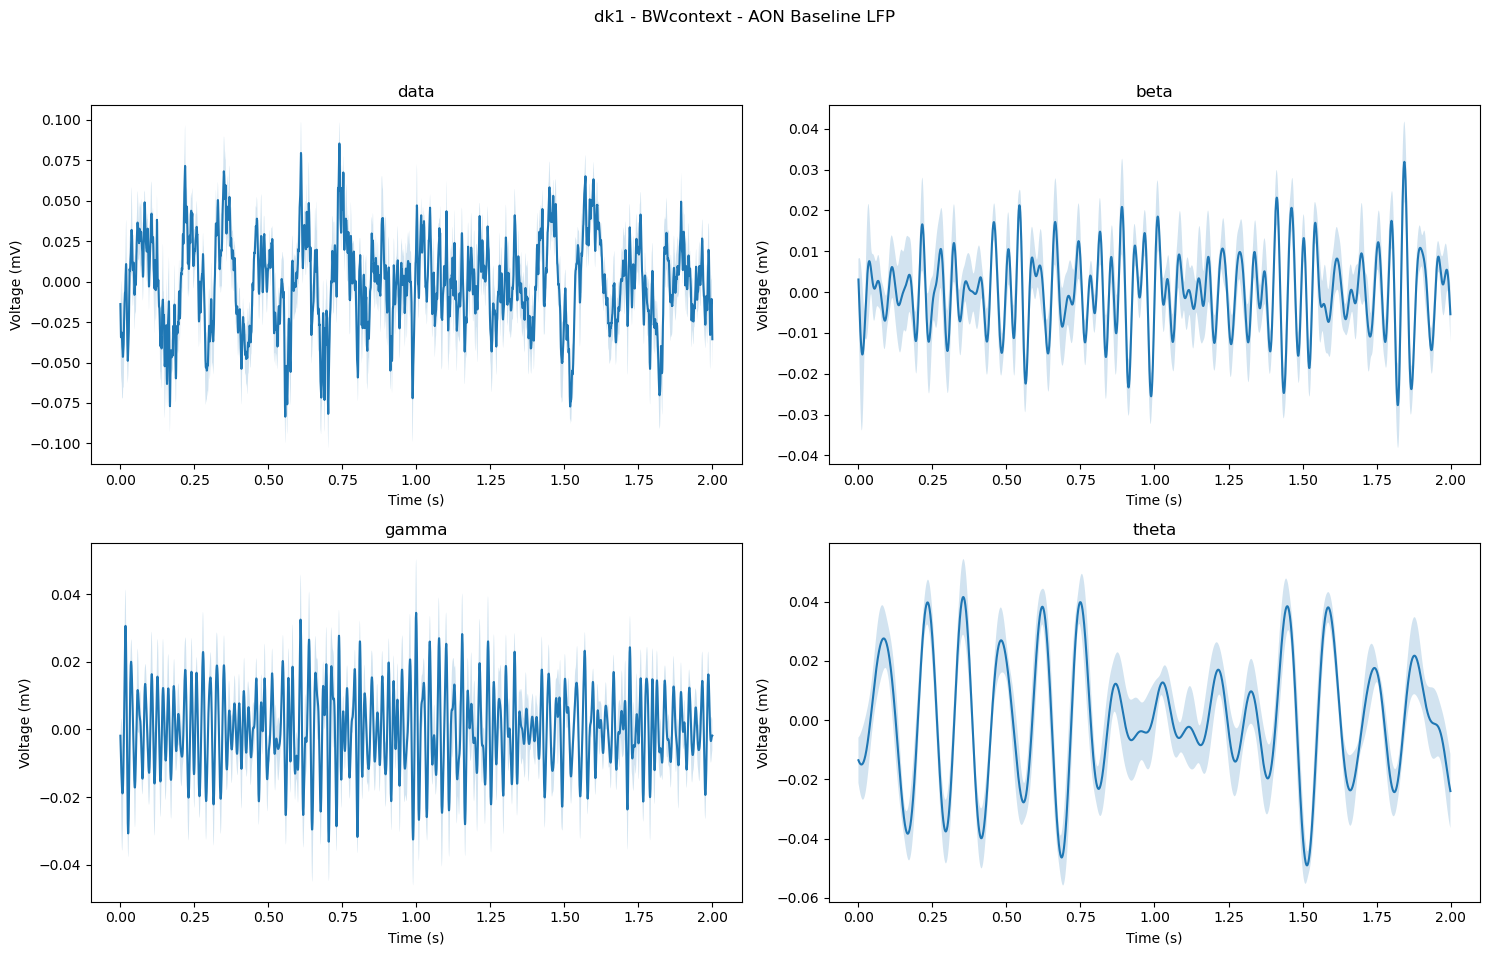

In [55]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

def calculate_lfp_mean_sem(band):
    # Assuming total_lfp is already defined and processed
    total_lfp = np.array(df[band].tolist())
    total_lfp = np.concatenate(total_lfp, axis=0)

    # Calculate mean and SEM
    total_lfp_mean = np.mean(total_lfp, axis=0)
    total_lfp_sem = scipy.stats.sem(total_lfp, axis=0)
    
    return total_lfp_mean, total_lfp_sem


fig, axs=plt.subplots(2,2, figsize=(15,10))
bands=['data','beta','gamma','theta']
for i,band in enumerate(bands):

    total_lfp_mean, total_lfp_sem = calculate_lfp_mean_sem(band)

    sampling_rate = 2000  # Hz
    duration = 2  # seconds
    num_points = sampling_rate * duration

    # Truncate the data to the first two seconds
    total_lfp_mean_2s = total_lfp_mean[:num_points]
    total_lfp_sem_2s = total_lfp_sem[:num_points]

    # Create the time array for the first two seconds
    time_2s = np.arange(0, duration, 1 / sampling_rate)

    axs[i//2,i%2].plot(time_2s,total_lfp_mean_2s)
    axs[i//2,i%2].fill_between(time_2s, total_lfp_mean_2s - total_lfp_sem_2s, total_lfp_mean_2s + total_lfp_sem_2s, alpha=0.2)
    axs[i//2,i%2].set_title(band)
    axs[i//2,i%2].set_xlabel('Time (s)')
    axs[i//2,i%2].set_ylabel('Voltage (mV)')
fig.suptitle(f'{rat} - {task} - {channel} Baseline LFP')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(f'{savepath}{rat}_{task}_{channel}_baseline_lfp.png')
plt.show()



In [ ]:

# Find the minimum length of the arrays in the 'data' column
min_length = min(len(data) for data in df['data'].values[0])

# Truncate each array in the 'data' column to the minimum length
df['data'] = df['data'].apply(lambda x: [arr[:min_length] for arr in x])

# Convert the truncated data to a NumPy array
truncated_data = np.array(df['data'].values[0])

# Check for NaN values and handle them
if np.isnan(truncated_data).any():
    print("Data contains NaN values. Handling NaNs by removing or imputing.")
    truncated_data = np.nan_to_num(truncated_data)  # Replace NaNs with zero or use another method

# Calculate the mean and SEM of the truncated data
df_total_mean = np.mean(truncated_data, axis=0)
df_total_sem = scipy.stats.sem(truncated_data, axis=0)

print(df_total_mean)
print(df_total_sem)


In [20]:
print(np.array(df['data'].values[0]).shape)
print(min_length)


(1, 60000)
60000


In [ ]:
rat_list=list(np.unique(compiled_data_all_epochs['rat']))
window=[-2,2] #Set the window for the the waveform

all_bands=['total','beta','gamma','theta']
band='total' #insert the band of interest

#rat_list=['dk1']
for rati in rat_list:
    rat_dict={}
    rat_data=compiled_data_all_epochs[compiled_data_all_epochs['rat']==rati]
    rat_data=rat_data.reset_index(drop=True)
    fig, axs=plt.subplots(2,2,figsize=(20,10))
    fig.suptitle(f'{rati} band {band} {window[0]}s to {window[1]}s')
    axs=axs.flatten()
    tasks=list(np.unique(rat_data['experiment']))
    print(tasks)
    for taski in tasks:
        rat_dict['experiment']=taski
        task_data=rat_data[rat_data['experiment']==taski]
        data_channels=np.unique(task_data['channel'])
        
        aon_channels=[channel for channel in data_channels if 'AON' in channel]
        vhp_channels=[channel for channel in data_channels if 'vHp' in channel]
        aon_data_door=[]
        vhp_data_door=[]
        aon_data_dig=[]
        vhp_data_dig=[]
        print(aon_channels)
        print(vhp_channels)
        if aon_channels:
            for aon_channeli in aon_channels:
                channel_data=task_data[task_data['channel']==aon_channeli]
                #print(taski, channeli,channel_data.shape)
                door_data=np.array(np.append(channel_data[band+'_pre_door'],channel_data[band+'_post_door'],axis=0))
                dig_data=np.array(np.append(channel_data[band+'_pre_odor'],channel_data[band+'_post_odor'],axis=0))
                aon_data_door=np.append(aon_data_door,door_data)
                aon_data_dig=np.append(aon_data_dig,dig_data)
        if vhp_channels:
            for vhp_channeli in vhp_channels:
                channel_data=task_data[task_data['channel']==vhp_channeli]
                #print(taski, channeli,channel_data.shape)
                door_data=np.array(np.append(channel_data[band+'_pre_door'],channel_data[band+'_post_door'],axis=0))
                dig_data=np.array(np.append(channel_data[band+'_pre_odor'],channel_data[band+'_post_odor'],axis=0))
                vhp_data_door=np.append(vhp_data_door,door_data)
                vhp_data_dig=np.append(vhp_data_dig,dig_data)
        aon_data_dig=np.array(aon_data_dig)
        aon_data_door=np.array(aon_data_door)
        vhp_data_dig=np.array(vhp_data_dig)
        vhp_data_door=np.array(vhp_data_door)
        
        data_dict={'AON LFP door':aon_data_door,'AON LFP dig':aon_data_dig,'vHp LFP door':vhp_data_door,'vHp LFP dig':vhp_data_dig}
        for i,datai in enumerate(list(data_dict.keys())):
            ax=axs[i]
            ax.set_title(datai)
            data=data_dict[datai]
            if data.size==0:
                continue
            data_mean=np.mean(data, axis=0)
            data_sem=scipy.stats.sem(data, axis=0)
            
            l=int(len(data_mean)/2+int(window[0]*2000))
            r=int(len(data_mean)/2+int(window[1]*2000))
            print(l,r)
            #print([4000-2000*int(abs(window[0])),4000+2000*int(abs(window[1]))])
            #print(len(data_mean))
            data_mean_windowed=data_mean[l:r]
            data_sem_windowed = data_sem[l:r]

            print(len(data_mean_windowed))
            
            time_axis = np.linspace(window[0], window[1], len(data_mean_windowed))
            ax.plot(time_axis, data_mean_windowed, label=taski)
            ax.fill_between(time_axis, data_mean_windowed - data_sem_windowed, data_mean_windowed + data_sem_windowed, alpha=0.2)
            
            ax.legend()
            ax.set_xlabel('Time(s)')            
    #fig.savefig(os.path.join(savepath,f'waveform {rati} {band}'),bbox_inches='tight',dpi=300)
    plt.show()
        

In [ ]:
channels=np.unique(waveform_df['channel'])
print(channels)
bands=['total_pre_door', 'total_post_door', 'total_pre_odor', 'total_post_odor',
                            'beta_pre_door', 'beta_post_door', 'beta_pre_odor', 'beta_post_odor',
                            'gamma_pre_door', 'gamma_post_door', 'gamma_pre_odor', 'gamma_post_odor',
                            'theta_pre_door', 'theta_post_door', 'theta_pre_odor', 'theta_post_odor']
for channel in channels:
    channel_df=waveform_df[waveform_df['channel']==channel]
    for bandi in bands:

        data=np.stack(channel_df[bandi].values)
        data_mean = np.mean(data, axis=0)
        plt.figure(figsize=(10, 5))
        
        # Plot individual rows as faint lines
        for row in data:
            plt.plot(row, color='gray', alpha=0.3)
        
        # Plot the mean as a prominent line
        plt.plot(data_mean, color='blue', linewidth=2)
        
        plt.title(f'{bandi} - Channel {channel}')
        plt.xlabel('Sample Index')
        plt.ylabel('Mean Value')
        plt.grid(True)
        plt.show()

In [ ]:
import pandas as pd
import numpy as np

channels = np.unique(waveform_df['channel'])
print(channels)
bands = ['total_pre_door', 'total_post_door', 'total_pre_odor', 'total_post_odor',
         'beta_pre_door', 'beta_post_door', 'beta_pre_odor', 'beta_post_odor',
         'gamma_pre_door', 'gamma_post_door', 'gamma_pre_odor', 'gamma_post_odor',
         'theta_pre_door', 'theta_post_door', 'theta_pre_odor', 'theta_post_odor']

for bandi in bands:
    band_df = waveform_df[[bandi]].copy()  # Extract the band column and make a copy
    band_df = pd.concat([band_df, waveform_df[['channel']]], axis=1)  # Concatenate along columns
    fig, axs=plt.subplots(len(channels),1, sharex=True)
    fig.suptitle(bandi)
    axs=axs.flatten()
    for i,channeli in enumerate(channels):
        channel_df=band_df[band_df['channel']==channeli]
        
        data=np.stack(channel_df[bandi].values)
        data_mean = np.mean(data, axis=0)
        ax=axs[i]
        # Plot individual rows as faint lines
        # for row in data:
        #     ax.plot(row, color='gray', alpha=0.3)
        
        # Plot the mean as a prominent line
        ax.plot(data_mean, color='blue', linewidth=2)
        ax.grid(True)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Signal Amp (uV)')
        ax.set_title(f' Channel {channeli}')

    plt.tight_layout()  # Adjust the vertical space between subplots
    plt.show()
        #continue  # Placeholder for further processing

Testing out the equality of the following. Given a signal -
1. Extract beta band signal from the signal, and the calculate its power
2. Calculate power spectrum of a signal and then extract Beta band power

In [19]:
import numpy as np
import scipy.signal as signal
from scipy.fft import fft

# Assume 'original_signal' and 'beta_signal' are already defined correctly
original_signal = compiled_data_all_epochs['total_post_door'][0]
beta_signal = compiled_data_all_epochs['beta_post_door'][0]

# Condition 1: Time-domain power (beta signal after bandpass filtering)
beta_signal_power = np.sum(beta_signal ** 2)
print("Condition 1 (Filtered signal power):", beta_signal_power)

# Condition 2: Frequency-domain power (using FFT)
# Compute FFT of the original signal
pxx = fft(original_signal)
n = len(original_signal)
# Frequency axis based on sample rate (Fs). Adjust Fs based on your data!
Fs = 2000  # Example: If your signal is sampled at 2000 Hz
faxis = np.linspace(0, Fs/2, n//2)  # Only take positive frequencies

# Compute the power spectrum (magnitude squared of FFT, normalized)
power_spectrum = (np.abs(pxx[:n//2]) ** 2) / n

# Find the indices corresponding to 12-30 Hz
beta_start = np.where(faxis >= 12)[0][0]
beta_end = np.where(faxis >= 30)[0][0]

# Sum the power in the 12-30 Hz band
beta_power_total = np.sum(power_spectrum[beta_start:beta_end])
print("Condition 2 (Power spectrum in 12-30 Hz):", beta_power_total)


Condition 1 (Filtered signal power): 902.0464004684507
Condition 2 (Power spectrum in 12-30 Hz): 601.1847286030982


Now I will make a stripplot containing power of beta power for all the animals taskaand channels


I will try to make the power spectrum

In [ ]:
from scipy.signal import welch, spectrogram

test=waveform_df['total_post_door'].iloc[0]
print(test)
f, Pxx = welch(test, fs=2000, nperseg=250, noverlap=100)
f = f[np.where(f<=100)] #select only frequencies below 100Hz
Pxx = Pxx[np.where(f<=100)]
plt.figure(figsize=(10,5))
plt.plot(f, Pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')

In [ ]:
from scipy.signal import welch
import numpy as np

total_events = ['total_pre_door', 'total_post_door', 'total_pre_odor', 'total_post_odor']
spectrum_dict={}
for event in total_events:
    aon_context=[]
    aon_nocontext=[]
    vhp_context=[]
    vhp_nocontext=[]
    for i in range(len(waveform_df)):
        test = waveform_df[event].iloc[i]
        f, Pxx = welch(test, fs=2000, nperseg=400, noverlap=None)
        f = f[np.where(f <= 100)]  # select only frequencies below 100Hz
        Pxx = Pxx[np.where(f <= 100)]
        if (waveform_df['experiment'].iloc[i] == 'BWcontext') and ('AON' in waveform_df['channel'].iloc[i]):
            aon_context.append(Pxx)
        elif (waveform_df['experiment'].iloc[i] == 'BWnocontext') and ('AON' in waveform_df['channel'].iloc[i]):
            aon_nocontext.append(Pxx)
        elif (waveform_df['experiment'].iloc[i] == 'BWcontext') and ('vHp' in waveform_df['channel'].iloc[i]):
            vhp_context.append(Pxx)
        elif (waveform_df['experiment'].iloc[i] == 'BWnocontext') and ('vHp' in waveform_df['channel'].iloc[i]):
            vhp_nocontext.append(Pxx)
        # Convert lists to numpy arrays
    aon_context = np.array(aon_context)
    aon_nocontext = np.array(aon_nocontext)
    vhp_context = np.array(vhp_context)
    vhp_nocontext = np.array(vhp_nocontext)
    
    spectrum_dict[event] = {'aon_context': aon_context, 'aon_nocontext': aon_nocontext,
                            'vhp_context': vhp_context, 'vhp_nocontext': vhp_nocontext}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming aon_context is already defined and is a 2D numpy array
# where rows are different samples and columns are the frequency bins

# Calculate the mean and standard error
mean_aon_context = np.mean(aon_context, axis=0)
stderr_aon_context = np.std(aon_context, axis=0) / np.sqrt(aon_context.shape[0])
mean_vhp_context = np.mean(vhp_context, axis=0)
stderr_vhp_context = np.std(vhp_context, axis=0) / np.sqrt(vhp_context.shape[0])
# Plot the mean line
plt.plot(f,mean_aon_context, label='Mean AON Context')
plt.plot(f,mean_vhp_context, label='Mean vHp Context')
# Plot the standard error shades
plt.fill_between(f,
                 mean_aon_context - stderr_aon_context, 
                 mean_aon_context + stderr_aon_context, 
                 color='b', alpha=0.2, label='Standard Error')
plt.fill_between(f,
                    mean_vhp_context - stderr_vhp_context,
                    mean_vhp_context + stderr_vhp_context,
                    color='r', alpha=0.2, label='Standard Error')
# Add labels and title
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('AON and vHp Context Power Spectral Density')
plt.legend()

# Show the plot
plt.show()

In [ ]:
for bandi in bands:
    band_df = waveform_df[[bandi]].copy()  # Extract the band column and make a copy
    band_df = pd.concat([band_df, waveform_df[['channel']]], axis=1)  # Concatenate along columns
    fig, axs=plt.subplots(len(channels),1, sharex=True)
    fig.suptitle(bandi)
    axs=axs.flatten()
    for i,channeli in enumerate(channels):
        channel_df=band_df[band_df['channel']==channeli]
        
        data=np.stack(channel_df[bandi].values)
        data_mean = np.mean(data, axis=0)
        ax=axs[i]
        # Plot individual rows as faint lines
        # for row in data:
        #     ax.plot(row, color='gray', alpha=0.3)
        
        # Plot the mean as a prominent line
        ax.plot(data_mean, color='blue', linewidth=2)
        ax.grid(True)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Signal Amp (uV)')
        ax.set_title(f' Channel {channeli}')

    plt.tight_layout()  # Adjust the vertical space between subplots
    plt.show()
        #continue  # Placeholder for further processing

In [ ]:
import numpy as np
import re

channels = np.unique(waveform_df['channel'])
print(channels)

for channel in channels:
    channel_df = waveform_df[waveform_df['channel'] == channel]
    
    # Convert string representations of arrays to actual numpy arrays
    def convert_to_array(x):
        if isinstance(x, str):
            # Remove any non-numeric characters except for commas, dots, and minus signs
            cleaned_str = re.sub(r'[^\d.,-]', '', x)
            # Convert the cleaned string to a numpy array
            return np.fromstring(cleaned_str, sep=',')
        else:
            return np.array(x)
    
    beta_pre_door_data = channel_df['beta_pre_door'].apply(convert_to_array)
    
    # Stack the values into a numpy array
    beta_pre_door_data = np.stack(beta_pre_door_data.values)
    
    # Calculate the mean along the specified axis
    beta_pre_door_mean = np.mean(beta_pre_door_data, axis=0)
    
    print(f"Mean of 'beta_pre_door' for channel {channel}: {beta_pre_door_mean}")